# Imports and Jupyter settings

In [2]:
%%html
<style>
.cm-s-ipython .CodeMirror-matchingbracket { color: LimeGreen !important;}
</style>

In [16]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pprint
from scipy import stats
import random
from datetime import datetime
import json
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from pandas import read_csv
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
import os
import json
import time
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
import os.path
from keras import backend as K
# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
import plotly.figure_factory as ff


In [4]:
from sklearn import preprocessing

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
pd.set_option('display.max_rows',500)

# Functions

In [57]:
def pre_process_df(df):
    
    #Drop unwanted columns
    df_dropped = df.drop(columns=['Unnamed: 0','Unnamed: 0.1',
                                  'stash_id','stash_feed','item_category',
                                  '_id',
                                  'date_month','date_year','item_name',
                                  'league','rarity',
                                  'price_currency','price_raw','date_day',
                                  'time_minutes'],errors='ignore')
    
    # delete columns with no values in them, which means only zero
    proc_df = df_dropped.loc[:,(df!=0).any (axis=0)]
        
    # Clean up of data. 
    ## Prices were imported as 'Object' not 'float'. We need to convert them to float.
    proc_df[['price_amount']] = pd.to_numeric(proc_df['price_amount'],errors='coerce')
    
    # Remove rows where price_amount is NaN
    proc_df = proc_df[pd.notnull(proc_df['price_amount'])]
    proc_df = proc_df.loc[proc_df['price_amount']!=0]
    
    return proc_df

def split_df_to_unique_item_names(df):

    unique_item_names = df['item_name'].value_counts(ascending=False)

    ascending_dataframes_per_name = {}

    for item_name in unique_item_names.index:
        dataF = df.loc[(df['item_name']== item_name)]
        if dataF.empty: continue
        if item_name not in ascending_dataframes_per_name:    
            ascending_dataframes_per_name[item_name] = dataF

    for item_name in ascending_dataframes_per_name:
        dataF = ascending_dataframes_per_name[item_name]
        dataF = dataF.loc[:,(dataF!=0).any(axis=0)]
        mask = dataF['price_amount'].notna()
        dataF = dataF[mask]
        ascending_dataframes_per_name[item_name] = dataF.reset_index()
        
    return ascending_dataframes_per_name

def compute_corr(df,method='spearman',filename=''):
    
    min_periods = int(len(df))*0.1
    cols = list(df.filter(regex='(Attacks per Second|Energy Shield|Elemental Damage|Critical Strike Chance|Physical Damage|influence|Armour|sockets_number|linked_sockets|Evasion Rating)|(?=^co_|ex_|im_|en_$)(^.*$)').columns.values)
    df[cols] = df[cols].replace({0:np.nan, 0.0:np.nan})
    #df[df.filter(regex='(?=^co_|ex_|im_|en_$)(^.*$)') <= 0.0] = np.nan
    corr = df.corr(method,min_periods = min_periods)
    corr = corr.dropna('columns',how='all')
    corr = corr.dropna('rows',how='all')
    
    return corr

def remove_outliers_IQR(item_dataframe,column_label = 'price_amount',high_quantile=0.75):
    '''Function removes outliers from a dataframe along the price_amount column by default.

    Input:
        df: pandas DataFrame
        column_label: along which column to check for outliers(default = 'price_amount')
        high_quantile: high-end quantile to use on boxplot'''
    
    Q1 = item_dataframe[column_label].quantile(1-high_quantile)
    Q3 = item_dataframe[column_label].quantile(high_quantile)
    IQR = Q3 - Q1
    new_df = item_dataframe[~((item_dataframe[column_label] < (Q1 - 1.5 * IQR))|(item_dataframe[column_label] > (Q3 + 1.5 * IQR)))]
    
    return new_df

def remove_outliers_zscore(item_dataframe,column_labels = ['price_amount'],threshold=3,show_results=False):
    '''Function removes outliers using z-score from a dataframe along the price_amount column by default.

    Input:
        df: pandas DataFrame
        column_label: along which columns to check for outliers(default = ['price_amount'])
        show_results: show results before and after removing outliers(default = False)
        size: vertical and horizontal size of the plot'''
    
    z_score = np.abs(stats.zscore(item_dataframe[column_labels]))
    new_df = item_dataframe[(z_score < threshold)]
    if show_results:
        data_outliers_index = np.where(z_score > threshold)[0]
        print('Data outliers for "{}":'.format(item_dataframe['item_name'][0]))
        for id in data_outliers_index:
              print('index: {:<10d}{}: {:<10f}'.format(id,column_labels[0],item_dataframe.iloc[id][column_labels[0]]))
        print('Removed {} rows'.format(item_dataframe.shape[0]-new_df.shape[0]))
    return new_df


def produce_decision_dataframe(item_df,correlations_df=pd.DataFrame,incl_outliers=True,method='z-score',threshold=2,quantile=0.8):
    
    d_df = item_df
    
    if not incl_outliers:
        if method == 'z-score' : 
            d_df = remove_outliers_zscore(d_df,threshold=threshold)
        elif method == 'IQR' :
            d_df = remove_outliers_IQR(d_df,high_quantile=quantile)
        else:
            raise Exception('\t\tWrong outlier mode. Valid options mode = [z-score | IQR]')
    
    if correlations_df.empty:
        columns = ['item_name','feature','corr_value','no_features','transactions','st_div','variance']
        correlations_df =  pd.DataFrame(columns=columns)
    
    corr=compute_corr(d_df,method='kendall')
    #corr_filtered = corr['price_amount'].filter(regex='(item_category|corrupted|Attacks per Second|Energy Shield|Elemental Damage|Critical Strike Chance|Physical Damage|influence|Armour|sockets_number|linked_sockets|Quality|Evasion Rating)|(?=^co_|ex_|im_|en_$)(^.*$)').drop(labels=['ex_conv_rate'],axis=0).dropna()
    corr_filtered = corr['price_amount'].filter(regex='(date_day|item_category|corrupted|Attacks per Second|Energy Shield|Elemental Damage|Critical Strike Chance|Physical Damage|influence|Armour|sockets_number|linked_sockets|Quality|Evasion Rating)|(?=^co_|ex_|im_|en_$)(^.*$)').dropna()
    for row in corr_filtered.index:
        correlations_df = correlations_df.append({'item_name':d_df['item_name'].unique()[0],
                                'feature':row,
                                'corr_value': corr_filtered[row],
                                'no_features':len(corr_filtered),
                                'transactions':d_df.groupby('item_name')['item_name'].count().values[0],
                                'st_div':d_df['price_amount'].describe()['std'],
                                'variance':d_df[['price_amount']].var(axis=0)},ignore_index=True)
    
    return correlations_df

def produce_corr_based_df(df_per_item_name,method='z-score',threshold=2,quantile=0.8):
    
    columns = ['item_name','feature','corr_value','no_features','transactions','st_div','variance']

    df =  pd.DataFrame(columns=columns)

    count = 0
    for dataF in df_per_item_name:
        count= count+1
        if count%200==0:
            print("Processed {} item_names".format(count))
        item_df = df_per_item_name[dataF]
        df = produce_decision_dataframe(item_df,df,incl_outliers=False,method=method,threshold=threshold,quantile=quantile)
        
    return df

def filter_decision_df(df, days=7, min_corr=0.1, min_no_features=2, min_std=5.0):
    
    min_trx = days*24
    
    df_filtered = df[(abs(df['corr_value'])>=min_corr) & \
                                          (df['transactions'] > min_trx) & \
                                          (df['st_div'] > min_std)]
    
    df_filtered['no_features'] = df_filtered.groupby('item_name')['item_name'].transform('count')
    df_filtered = df_filtered[df_filtered['no_features'] >= min_no_features]
    
    return df_filtered

def convert_column_values_string_to_rankInt(df) -> pd.DataFrame:
    for column in df.columns:
        if df[column].dtype == type(object):
            le = preprocessing.LabelEncoder()
            df[column] = le.fit_transform(df[column])
    return df

def flatten_column(df_column,method='median',round_base=2):
    if method=='median':
        return df_column.median()
    elif method=='mean':
        return round(df_column.mean(),round_base)
    
def interpolate_df(df,config):
    feature_series = []
    index = []
    item_features = df.columns
    for feature in item_features:
        if feature in config['features']:
            if config['features'][feature]=='median':
                inter_series_f = flatten_column(df[feature],method='median')
            elif config['features'][feature]=='mean':
                inter_series_f = flatten_column(df[feature],method='mean')
            else:
                inter_series_f = flatten_column(df[feature],method=config['default_flatten'])
        else:
            inter_series_f = flatten_column(df[feature],method=config['default_flatten'])
        
        index.append(feature)
        feature_series.append(inter_series_f)
    return pd.Series(feature_series,index)

def fill_and_plot(df,method='default',order=3):
    if method in ['spline','polynomial']:
        df_inter = df.interpolate(method=method,order=order)
    else:
        df_inter = df.interpolate(method=method)
    plt.figure(figsize=(20,10))
    df_inter['price_amount'].plot()
    plt.legend([method])
    return df_inter


def fill_time_periods(df,method = 'pchip',order=3):

    if method in ['spline','polynomial']:
        df = df.interpolate(method=method,order=order)
    else:
        df = df.interpolate(method=method)
    return df

def feature_selection(df, method="decision_tree",verbose=0,importance_threshold=0.15,max_no_of_features = 5):
    important_features = []
    train = df.copy()
    new_df = df.drop(['price_amount','time','date','socket_colors','time_hours'],axis=1,errors='ignore')
    if method=='decision_tree':
        model = RandomForestRegressor(random_state=12,max_depth=100)
        new_df = pd.get_dummies(new_df)
        model.fit(new_df,train.price_amount)
        features = new_df.columns
        importances = model.feature_importances_
        indices = np.argsort(importances)[-max_no_of_features:]  # top 10 features
        if verbose:
            for i in indices:
                print("Feature : {:40} --->importance [{}]".format(features[i][:40],importances[i].round(3)))
        for i in indices:
            if importances[i] > importance_threshold:
                important_features.append(features[i])
        important_features.append('price_amount')
        print("Important_features length : {}".format(len(important_features)))
        return important_features
    elif method=='rfe':
        lreg = DecisionTreeRegressor()
        rfe = RFE(lreg, max_no_of_features-1)
        cols = new_df.columns
        rfe = rfe.fit(new_df, train.price_amount)
        sorted_ranking = sorted(zip(map(lambda x:round(x,5),rfe.ranking_),cols))
        
        for i in range(0,len(sorted_ranking)):
            if verbose==1: print("Feature : {:40} has weight [{}]".format(sorted_ranking[i][1][:35],sorted_ranking[i][0]))
#             if (sorted_ranking[i][0] <= max_no_of_features*0.3 and (len(important_features)<(max_no_of_features))):    
            if (len(important_features)<(max_no_of_features-1)):
                important_features.append(sorted_ranking[i][1])
                
        important_features.append('price_amount')
        return important_features
 

# Classes

In [9]:
class Model():

    def __init__(self,):
        self.model = Sequential()

    def build_model(self, configs,no_of_features):

        for layer in configs['model']['layers']:
            neurons = layer['neurons'] if 'neurons' in layer else None
            dropout_rate = layer['rate'] if 'rate' in layer else None
            activation = layer['activation'] if 'activation' in layer else None
            return_seq = layer['return_seq'] if 'return_seq' in layer else None
            input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
            input_dim = no_of_features
            
            if layer['type'] == 'dense':
                self.model.add(Dense(neurons, activation=activation))
            if layer['type'] == 'lstm':
                self.model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
            if layer['type'] == 'dropout':
                self.model.add(Dropout(dropout_rate))

        self.model.compile(loss=configs['model']['loss'], optimizer=configs['model']['optimizer'])
        
        model_json = self.model.to_json()
        with open("model.json", "w") as json_file:
            json_file.write(model_json)
            
        print('[Model] Model Compiled')
        
    def fit_model(self,train_X,train_y,test_X,test_y,configs):
        epochs = configs['training']['epochs']
        batch_size = configs['training']['batch_size']
        early_stop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=round(epochs*0.1),
                              verbose=0, mode='auto')
        self.history = self.model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=1, shuffle=False,callbacks=[early_stop])
        
    def plot_history(self):
        pyplot.figure(figsize=(20,10))
        pyplot.plot(self.history.history['loss'], label='train')
        pyplot.plot(self.history.history['val_loss'], label='test')
        pyplot.legend()
        pyplot.show()

    def predict_yhat(self,test_X):
        return self.model.predict(test_X)
        

In [66]:
class DataLoader():
    """A class for loading and transforming data for the lstm model"""

    def __init__(self, filename,config, inter_config):
        self.lag = config['data']['lag']
        self.forec_seq = config['data']['forecasted_seq']
        
        self.dataF = pd.read_csv(filename,delimiter='^').round(2)

        self.prepared_data = self.prepare_data(self.dataF,config,inter_config)

        self.no_features = self.prepared_data.shape[1]
        self.reframed_norm_data = self.normalize_data(self.prepared_data,config['data']['lag'],config['data']['forecasted_seq'])
        
        self.data_train, self.data_test = self.split_data(self.reframed_norm_data,config['data']['train_test_split'])
        
        
    def rearrange_yhat_to_first_column(self,df,yhat_name='price_amount'):
        
        rearranged_columns = ['price_amount']
        for c in df.columns:
            if c=='price_amount' :continue
            rearranged_columns.append(c)
        return df[rearranged_columns]
    
    def normalize_data(self,df,sequence_length,forecasted_sequence):
        dataset = self.rearrange_yhat_to_first_column(df)
        values = dataset.values
        
        # ensure all data is float
        values = values.astype('float32')

        # normalize features
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = self.scaler.fit_transform(values)

        # frame as supervised learning
        reframed = self.series_to_supervised(scaled, sequence_length, forecasted_sequence)

        # drop columns we don't want to predict
        self.unwanted_predicted_multiv_features = dataset.shape[1]-1
        reframed = self.remove_uwanted_pred_multiv_features(reframed,self.unwanted_predicted_multiv_features)
        return reframed
    
    def split_data(self,reframed_df,train_test_split):
        
        n_train_hours = int(round(reframed_df.shape[0]*(1-train_test_split)))
        print(n_train_hours)
        # split into train and test sets
        values = reframed_df.values
        
#         n_train_hours = 164
        train = values[:n_train_hours, :]
        test = values[n_train_hours:, :]
    
        return train,test
    
    def get_train_data(self):
        train_X, train_y = self.data_train[:,:-1],self.data_train[:,-1]
        train_X = train_X.reshape((train_X.shape[0], self.lag+self.forec_seq-1, self.no_features))
        return train_X,train_y
        
    def get_test_data(self):
        test_X, test_y = self.data_test[:,:-1],self.data_test[:,-1]
        test_X = test_X.reshape((test_X.shape[0], self.lag+self.forec_seq-1, self.no_features))
        return test_X,test_y
        
    def prepare_data(self,df,config,inter_config):
        
        item_name = df['item_name'].unique()[0]
        item_inter_conf = inter_config[item_name]
        no_of_features = config['data']['no_of_features']
        corr_threshold = config['data']['corr_threshold']
        inter_frequency = item_inter_conf['frequency']
        
        #remove unwanted columns and rows
        df = pre_process_df(df)
        
        #Remove outliers
        outlier_conf = config['data']['outliers']
        if outlier_conf['method']=='IQR':
            df = remove_outliers_IQR(df,high_quantile=outlier_conf['high_quantile'])
        if outlier_conf['method']=='z_score':
            df = remove_outliers_zscore(df,threshold=outlier_conf['threshold'])
        
        #Feature selection prep
        important_features = feature_selection(df,method='rfe',verbose=0,importance_threshold=corr_threshold,max_no_of_features=no_of_features)
#         print(important_features)
        #Make a dateTime type column to interpolate with later
        d = df['date'] + '-'+df['time']
        df['date_time'] =  pd.to_datetime(d, format='%Y-%m-%d-%H-%M')
        df = df.set_index("date_time")
        
        #Actual feature selection
        df = df[important_features]
        self.unfilled_prepared = df.copy()
        self.no_features = df.shape[1]
        
        #Interpolation
        df1 = df.groupby(pd.Grouper(freq=inter_frequency,closed='left')).apply(lambda x: interpolate_df(x,item_inter_conf))
        df1 = df1.resample(inter_frequency).asfreq()
        filled_df = fill_time_periods(df1,item_inter_conf['fill_method']).round(2)
        
        
        return filled_df
    # convert series to supervised learning
    def series_to_supervised(self,data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg
    
    def remove_uwanted_pred_multiv_features(self,df,no_of_features):
        return df.iloc[:,:-no_of_features]
    
    def get_inverted_predictions(self,yhat,test_X,test_y):
        new_test_x = test_X.reshape((test_X.shape[0], self.lag*self.no_features))

        # invert scaling for forecast
        inv_yhat = concatenate((yhat, new_test_x[:, -self.unwanted_predicted_multiv_features:]), axis=1)
        inv_yhat = self.scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]

        # invert scaling for actual
        new_test_y = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((new_test_y, new_test_x[:, -self.unwanted_predicted_multiv_features:]), axis=1)
        inv_y = self.scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]

        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

        print('Test RMSE: %.3f' % rmse)
        
        return inv_yhat,inv_y
        
    def plot_prediction_to_real(self,inv_yhat,inv_y):
        compare_outputs_df = DataFrame(inv_y)
        compare_outputs_df = compare_outputs_df.rename({0:'real'},axis=1)
        compare_outputs_df['predicted'] = inv_yhat
        plt.figure(figsize=(30,20))
        plt.plot(compare_outputs_df)

# Tabula analysis

39


(390, 49)

(39, 24, 2) (39,) (351, 24, 2) (351,)
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
[Model] Model Compiled
Train on 39 samples, validate on 351 samples
Epoch 1/500
39/39 [==============================] - 1s 32ms/step - loss: 0.0757 - val_loss: 0.1773
Epoch 2/500
39/39 [==============================] - 0s 8ms/step - loss: 0.0293 - val_loss: 0.1010
Epoch 3/500
39/39 [==============================] - 0s 7ms/step - loss: 0.0070 - val_loss: 0.0571
Epoch 4/500
39/39 [==============================] - 0s 8ms/step - loss: 0.0052 - val_loss: 0.0433
Epoch 5/500
39/39 [==============================] - 0s 8ms/step - loss: 0.0073 - val_loss: 0.0435
Epoch 6/500
39/39 [==============================] - 0s 8ms/step - loss: 0.0059 - val_loss: 0.0473
Epoch 7/500
39/39 [==============================] - 0s 8ms/step - loss: 0.0046 - val_loss: 0.0496
Epoch 8/500
39/39 [==============================] - 0

Epoch 76/500
39/39 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0259
Epoch 77/500
39/39 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0257
Epoch 78/500
39/39 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0254
Epoch 79/500
39/39 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0251
Epoch 80/500
39/39 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0248
Epoch 81/500
39/39 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0245
Epoch 82/500
39/39 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0243
Epoch 83/500
39/39 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0240
Epoch 84/500
39/39 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0237
Epoch 85/500
39/39 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0234


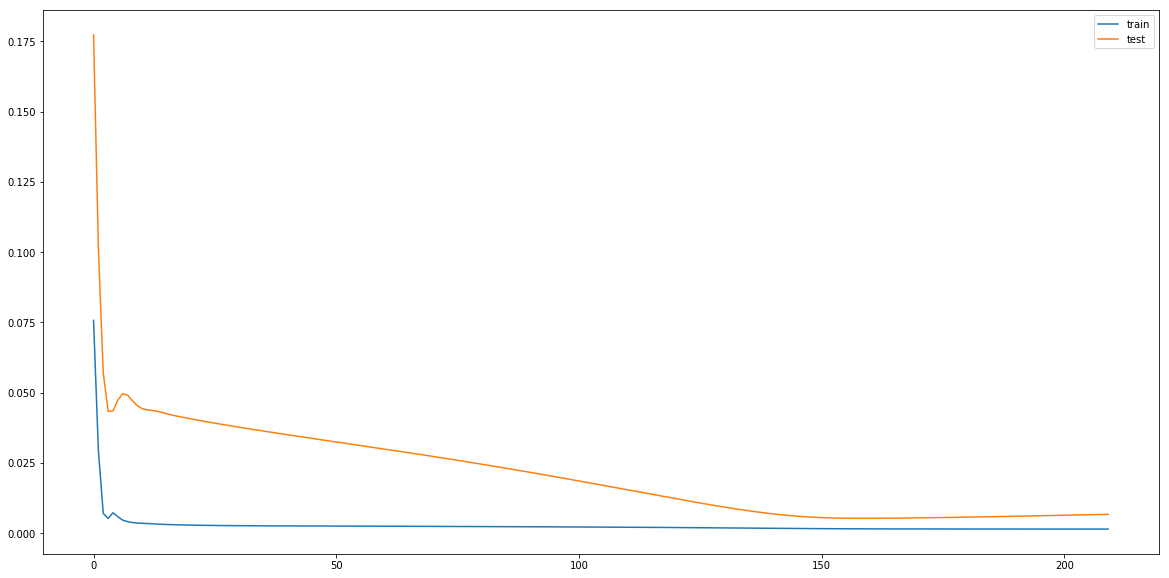

Test RMSE: 0.605


<Figure size 2160x1440 with 0 Axes>

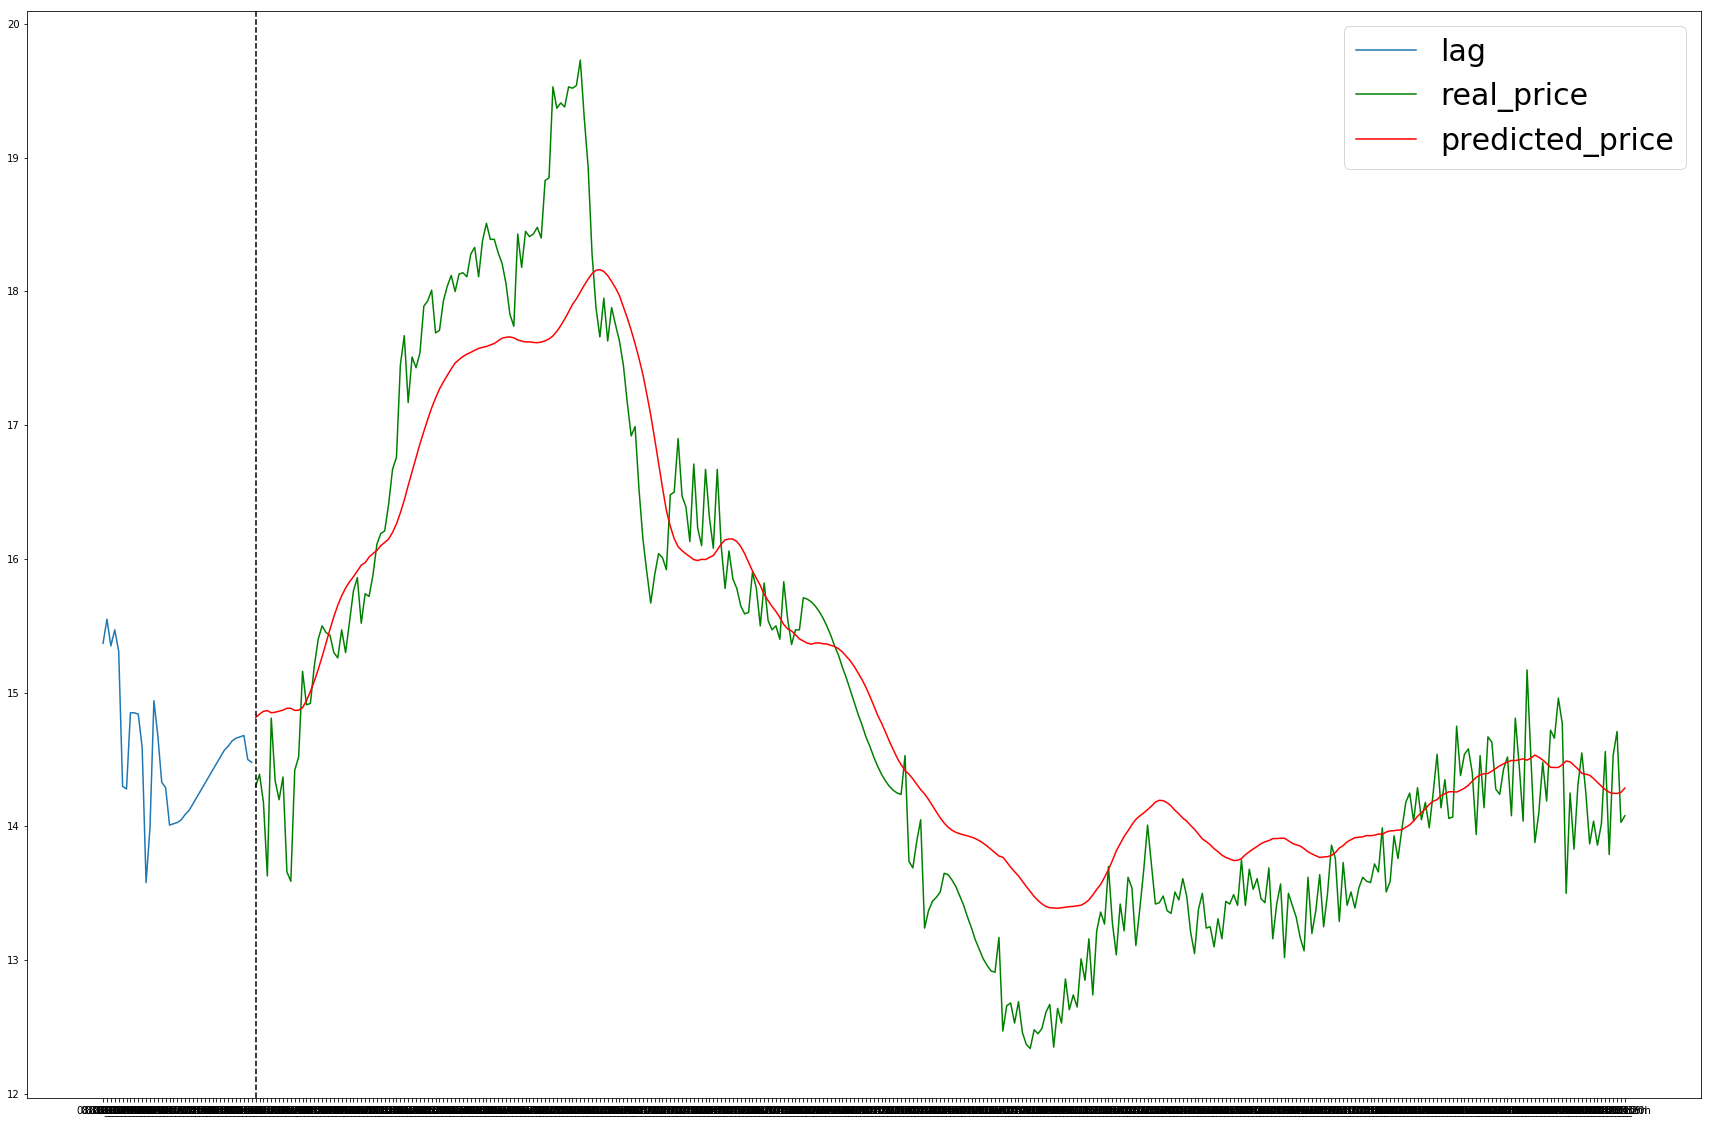

In [11]:
configs = json.load(open('tabula_config.json', 'r'))
inter_conf = json.load(open('interpolation_config.json', 'r'))

data = DataLoader(configs['data']['filename'],configs,inter_conf)
data.reframed_norm_data.shape

# data.data_train.shape
# data.data_test.shape

# train_X,train_y = data.get_train_data()
# test_X,test_y = data.get_test_data()

# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# model = Model()
# model.build_model(configs,train_X.shape[2])
# model.fit_model(train_X,train_y,test_X,test_y,configs)
# model.plot_history()

# yhat = model.predict_yhat(test_X)
# inv_yhat , inv_y = data.get_inverted_predictions(yhat,test_X,test_y)

# new_train_y = train_y.reshape((len(train_y), 1))
# inv_train_y = concatenate((new_train_y, new_train_y[:, -data.unwanted_predicted_multiv_features:]), axis=1)
# inv_train_y = data.scaler.inverse_transform(inv_train_y)
# inv_train_y = inv_train_y[:,0]

# lag_train_values = []
# lag_train_values.append(data.prepared_data['price_amount'][:data.lag].values)
# lag_train_values.extend(inv_train_y[1:])
# lag_train_len = len(lag_train_values)

# train_df = DataFrame(inv_train_y)
# for i in range(0,inv_yhat.shape[0]):
#     train_df = train_df.append({0:np.nan},ignore_index=True)
    
# compare_outputs_df = pd.DataFrame()
# for i in range(0,lag_train_len):
#     compare_outputs_df = compare_outputs_df.append({0:np.nan},ignore_index=True)
# df = DataFrame(inv_y)
# compare_outputs_df= compare_outputs_df.append(df,ignore_index=True)
# compare_outputs_df = compare_outputs_df.rename({0:'real'},axis=1)
# df = []
# for i in range(0,lag_train_len):
#     df.append(np.nan)
# for i in range(0,inv_yhat.shape[0]):
#     df.append(inv_yhat[i])
    
# compare_outputs_df['predicted'] = df
# time_index = data.prepared_data.index[data.lag:].strftime("%d-%m_%Hh")
# compare_outputs_df = compare_outputs_df.set_index(time_index)
# plt.figure(figsize=(30,20))
# plt.plot(train_df, label='lag')
# plt.plot(compare_outputs_df['real'],color='green', label='real_price')
# plt.plot(compare_outputs_df['predicted'],color='red', label='predicted_price')
# plt.axvline(len(train_y), color='black', linestyle='--')
# plt.xticks(rotation=70)
# plt.legend(loc='upper right', prop={'size': 30})

# Windripper analysis

39


(390, 49)

(39, 24, 2) (39,) (351, 24, 2) (351,)
[Model] Model Compiled
Train on 39 samples, validate on 351 samples
Epoch 1/1000
39/39 [==============================] - 3s 72ms/step - loss: 0.0670 - val_loss: 0.1375
Epoch 2/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0327 - val_loss: 0.0880
Epoch 3/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0108 - val_loss: 0.0558
Epoch 4/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.0421
Epoch 5/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0038 - val_loss: 0.0397
Epoch 6/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0039 - val_loss: 0.0418
Epoch 7/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0449
Epoch 8/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0028 - val_loss: 0.0467
Epoch 9/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0029 - val_loss: 

39/39 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 162/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 163/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 164/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 165/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0043
Epoch 166/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0043
Epoch 167/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0043
Epoch 168/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 169/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 170/1000
39/39 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.

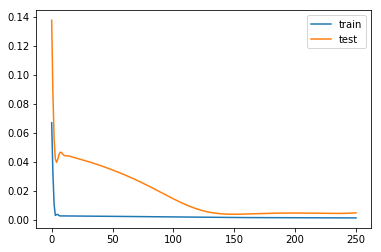

Test RMSE: 0.521


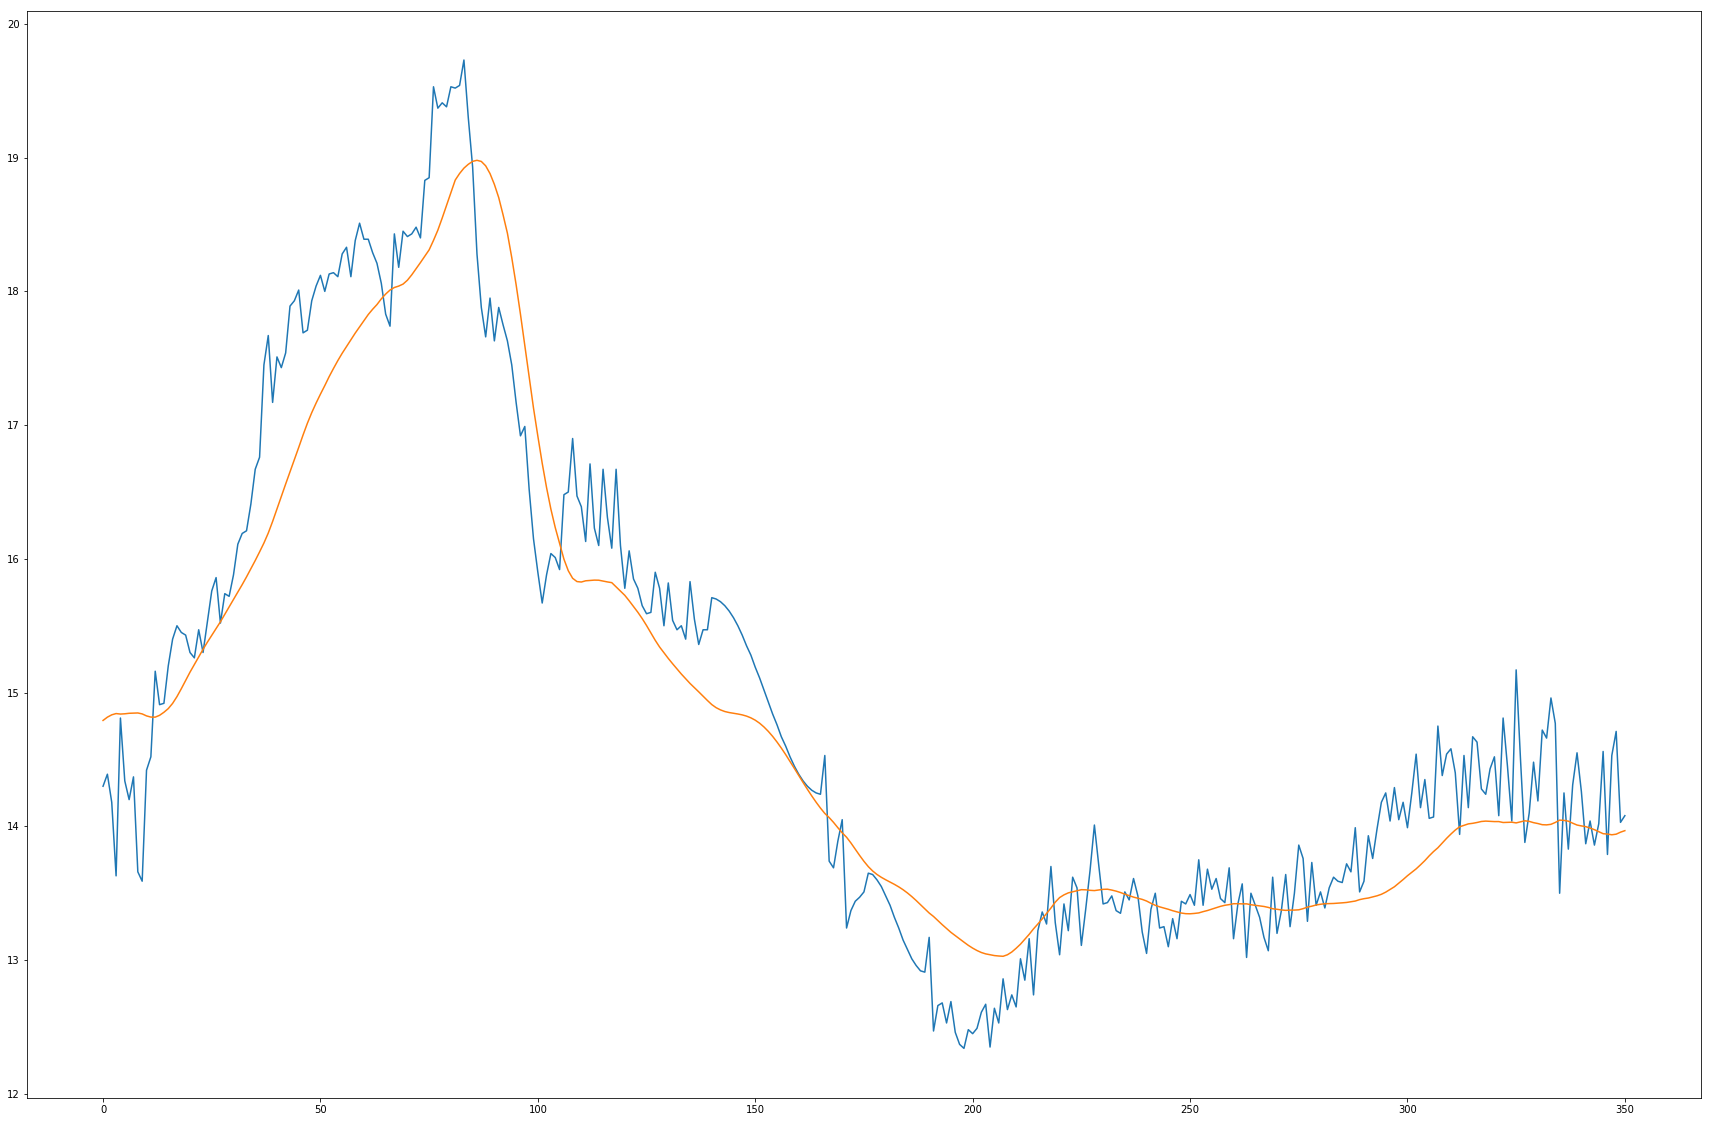

In [34]:
configs = json.load(open('windripper_config.json', 'r'))
inter_conf = json.load(open('interpolation_config.json', 'r'))

data = DataLoader(configs['data']['filename'],configs,inter_conf)
data.reframed_norm_data.shape

# data.data_train.shape
# data.data_test.shape

train_X,train_y = data.get_train_data()
test_X,test_y = data.get_test_data()

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

model = Model()
model.build_model(configs,train_X.shape[2])
model.fit_model(train_X,train_y,test_X,test_y,configs)
model.plot_history()

yhat = model.predict_yhat(test_X)
inv_yhat , inv_y = data.get_inverted_predictions(yhat,test_X,test_y)

new_train_y = train_y.reshape((len(train_y), 1))
inv_train_y = concatenate((new_train_y, new_train_y[:, -data.unwanted_predicted_multiv_features:]), axis=1)
inv_train_y = data.scaler.inverse_transform(inv_train_y)
inv_train_y = inv_train_y[:,0]

lag_train_values = []
lag_train_values.append(data.prepared_data['price_amount'][:data.lag].values)
lag_train_values.extend(inv_train_y[1:])
lag_train_len = len(lag_train_values)

train_df = DataFrame(inv_train_y)
for i in range(0,inv_yhat.shape[0]):
    train_df = train_df.append({0:np.nan},ignore_index=True)
    
compare_outputs_df = pd.DataFrame()
for i in range(0,lag_train_len):
    compare_outputs_df = compare_outputs_df.append({0:np.nan},ignore_index=True)
df = DataFrame(inv_y)
compare_outputs_df= compare_outputs_df.append(df,ignore_index=True)
compare_outputs_df = compare_outputs_df.rename({0:'real'},axis=1)
df = []
for i in range(0,lag_train_len):
    df.append(np.nan)
for i in range(0,inv_yhat.shape[0]):
    df.append(inv_yhat[i])
    
compare_outputs_df['predicted'] = df
time_index = data.prepared_data.index[data.lag:].strftime("%d-%m_%Hh")
compare_outputs_df = compare_outputs_df.set_index(time_index)
plt.figure(figsize=(30,20))
plt.plot(train_df, label='lag')
plt.plot(compare_outputs_df['real'],color='green', label='real_price')
plt.plot(compare_outputs_df['predicted'],color='red', label='predicted_price')
plt.axvline(len(train_y), color='black', linestyle='--')
plt.xticks(rotation=70)
plt.legend(loc='upper right', prop={'size': 30})